# Volumetric Surface Reconstruction.

In [1]:
from mylibs.Dino_Images import *
from mylibs.triangluation import *
from mylibs.reconstruction import *
from mylibs.triangulation_outlier_removal import *
from mylibs.background_removal import *

# Suppress Warnings
import warnings, os
warnings.filterwarnings('ignore')

# File Loader
DI = Dino_Images(input_dic_path=os.path.join("imgs", "dino"), par_path="/dino_par.txt")

%matplotlib inline

**NOTE**: Details on the implementation of the external libraries are in the Environment section in the README.md markdown file. Please visit our Github repo for more detail: https://git.uwaterloo.ca/s362xu/volumetric-surface-reconstruction

## Abstract

Using image data with known camera positions, we applied triangulation and recreated a 3D surface of an object. We used different methods to detect the object and backgrounds and then produced a list of sampled inliers for the triangulation. Camera views were taken into account sequentially, comparing views pairwise to find inlier points not already found in previous views. To minimize the reprojection error, two approaches were taken. Minimize the error before and after triangulation. Afterward, the final volumetric surface was reconstructed using an automatic segmentation technique. Different methods of reconstruction were also experimented with.

## Team Members and Contributions:

The work is split between three team members by functional components in the workflow. 

#### Min Gyu Woo (mgwoo)
- Pair-Wise Triangulation
- Fundamental Matrix Estimation 
- Convolutional Absolute Intensity Difference Method in Pair-Wise Matching
- Outlier Remover Methods:
    - K-means on the distance between points and mean/median
    - Multivariate Gaussian Distribution
    - One nearest neighbor
    - IQR test

#### Leon Yao (lclyao) 
- Dataloader Implementation
- Triangulation Order Optimization
- Spatial Consistency between Epipolar Lines in Pair-Wise Matching
- Hyper-parameter Tuning 
- Exploratory Analysis on Other Conventional Methods

#### Sijie Xu (s362xu) 
- Background Removal Implementation
- Normalized Linear Kernal Correlation Coefficient Method in Pair-Wise Matching
- Outlier Remover Methods:
    - Distance Cutoff based on Mean/Median on Population 
    - Log-Likelihood Cutoff based on Gaussian Mixture Models
- Convex/Concave Optimization Methods
- Decent Amount of Housekeeping

## Data Loader (Dino_images.py)

The sample data was given in multiple text files and image files. We read the data line by line from 'par.txt' files to get the calibration matrix, rotation matrix, and translation vector of each camera. We also wrote a method to find the order to triangulate points. This order was computed by taking the camera from the first image as camera 1, and then selecting the camera closest in rotation and position to camera 1 as camera 2, and repeating this process, finding the ($i+1$)-th camera as the one closest in rotation and position to the $i$-th camera.

## Calculating the Fundamental Matrix F

The fundamental matrix was calculated based on the paper by Ghosh, Sourish.

Given two non-calibrated cameras, define the camera center as $C, C'$ respectively, homogenous image points $x, x'$ respectively, and corresponding homogenous 3D point as $X$.

The goal is to find a transformation F that maps an image point in the first camera to an epipolar line in the second camera. In other words,

$$l' = Fx$$

To obtain the epipole of the right image, we need to project the camera center $C$ of the first camera to the second camera's image plane,

$$e' = P'C$$

Now, to project a 3D point $X$ onto the camera-centered coordinates for the first camera, the projection matrix of the first camera must be used with the 3D pint:

$$PX = x$$. 

If point $X$ is to be recovered, the following one-parameter equation is used:

$$X(\lambda) = P^{+}x + \lambda C$$

NOTE: Since $P$ is not square, it is using a pseudo-inverse denoted as $P^{+}$.

Since $X$ is in homogenous coordinates, $\lambda = 0 \implies X = P^{+}x$ and $\lambda = \infty \implies X = C$ (which corresponds to the illegal $(0,0,0)$ case). Using the projection matrix of the second image, we get $P'P^{+}x$ and $P'C$ respectively, to get points in the camera center coordinates of the second camera. Note that $P'C$ is the epipole located in the second image. Calculating the cross product of these two vectors produces the normal of the epipolar plane.

$$n = (P'C)\times(P'P^{+}x)$$

Thus, finding points $x'$ such that:

$$x'n=0$$

This represents that $x'$ is on the epipolar line.


$$
\begin{aligned}
x'n & = 0 \\
x'(P'C)\times(P'P^{+}x) & = 0 \\
x'[e']_{\times}P'P^{+}x &= 0 \\
x'Fx &= 0
\end{aligned}
$$

Therefore, the fundamental matrix is defined as:

$$F = [e']_{\times}P'P^+$$

After computing the order of the cameras we should triangulate points in, we compare views between camera $i$ and camera $(i+1)$ in order to find points that have not already been triangulated. We can compute the projection matrices $P_i, P_{i+1}$ from the sample data given $K_i, R_i, T_i, K_{i+1}, R_{i+1}, T_{i+1}$. Thus, define the projection matrices as:

$$P_{i} = K_{i}[R_i \mid T_i], P_{i+1} = K_{i+1}[R_{i+1} \mid T_{i+1}]$$ 
    
We can then use the formula described above to get the Fundamental matrix $F$ from $P_i, P_{i+1}$ and camera centers $C_i = T_i, C_{i+1} = T_{i+1}$. 

Next, we can sample points from the view $i$. As we have already segmented the photos into the object and the background, we can sample by randomly picking points with intensity greater than a certain tuned threshold parameter and, by doing so, will avoid background pixels that have been set to $0$ intensity (explained below). 

From these sampled points, we can match them to the $i+1$th view and triangulate them using pair matching and triangulation methods listed above. The triangulated points then get added to an overall list of points, along with the corresponding camera and image pair. We can then graph all the points from the different camera views into one single point cloud and use a meshing algorithm to generate an approximation of the mesh of the object.

## Finding Matching Pairs (openCV)

### Background Removal

In this section, we want to compare different background removal procedures to get the best result. The reason behind segmenting the background from the object is to make sure we only perform 3D reconstruction on the object.

#### Historgram-Based Naive Segmentation 

A naive approach is to select the points with a cutoff threshold. Here, we applied a color threshold on every pixel on the image. Pixels which have color intensity $r, g, b$ which $r + g + b < threshold$ is considered the background. 

#### Stereo Depth Matching Segmentations 

Since we have stereo images (for the dinoRing and dinoSparseRing dataset), distinguishing the background from the object can be done using the depth detection algorithm in the hope that the background is labeled in a different depth than the object. Since the relative position between stereo camera points is small, we assume them to be at the same position. Hence, we can use RANSAC to find the homogenous matrix for wrapping the second image to the same plane. Here we used a simple disparity calculation using the distance between points in the image plane corresponding to the 3D scene point and their camera center. We apply the epipolar line constraint to find matching points along the same epipolar.

#### K-Means Segamentation

Here we implemented the K-means segmentation algorithm based on three pixels features, namely the intensity $I$, $x$, and $y$ location. We applied $\epsilon$ on the $x$ and $y$ location to lower the penalty on location inconsistency. Essentially we use $k = 3$, and initialize the k-means center by selecting the top-left, bottom-right and centre pixel. By doing so, we ensure that the object is always located in the center clustering.  

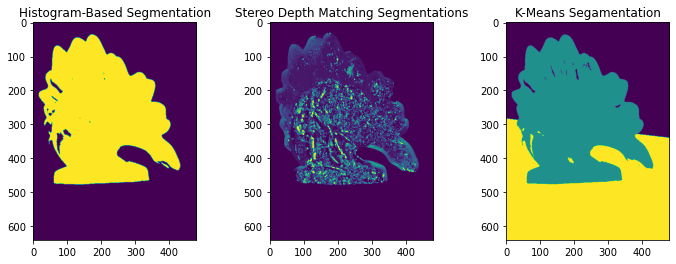

In [2]:
# Histogram-Based Segmentation
mask_naive, _ = background_remover_naive(rotate(DI.image_list[0], 90, resize = True))

# Stereo Depth Matching Segmentations
imgL_rotate = img_as_ubyte(rotate(DI.image_list[0], 90, resize = True))
imgR_rotate = img_as_ubyte(rotate(DI.image_list[1], 90, resize = True))
mask_depth, _ = background_remover_depth(imgL_rotate, imgR_rotate, DI.T_Matrix[0], DI.T_Matrix[1])

# K-Means Segamentation
mask_km = background_remover_k_clustering(rotate(DI.image_list[0], 90, resize = True))


plt.figure(4,figsize = (12, 4))

ax1 = plt.subplot(131)
plt.imshow(mask_naive)
ax1.title.set_text('Histogram-Based Segmentation')

ax2 = plt.subplot(132)
plt.imshow(mask_depth)
ax2.title.set_text('Stereo Depth Matching Segmentations')

ax3 = plt.subplot(133)
plt.imshow(mask_km)
ax3.title.set_text('K-Means Segamentation')

#### Auto Background Removal by Adobe

We also used the auto background segmentation algorithm provided in Adobe Photoshop. This approach consists of using a deep neural network encoder and decoder structure. The network is trained with a data set of 49,300 images, and the algorithm seems to have learned well. The structure of the neural network is as follows:

![title](imgs/encoderdecoderadobe.png)

We use the Adobe photoshop action tools to automate the entire background removal process in one click. The original images (left) are compared with the alpha channel predicted by the neural network in the paper (right) [Xu, 2017]:

<div>
<img src="imgs/adobeexample.png" width="300"/>
</div>

### Pair Matching

For given dots on the first image denoted by $x_i$, it is possible to find a corresponding epipolar line $l_i$ on the second image given the fundamental matrix $F$. The naive approach is to perform pattern matching using color intensity along the epipolar line. However, it is still challenging to find the true matching pairs on the second image due to the following reasons:
* Error in fundamental matrix estimation
* Error in epipolar line $l_i$ estimation

Hence, it is essential to develop a robust way of finding the matched point.

#### Convolutional Absolute Intensity Difference Method

First of all, we implemented a simple method where similar to the integral image (but with pixel $p$ being the center of the bounding box size); the intensity values were cropped for all points on $l_i$ and compared with the cropped intensity values on point $p\in x_i$ in the first image (given a bounding box size of $2*bbr$ where $bbr$ is the bounding box radius). Then, the points on $l_i$ that minimize the sum of the absolute differences of the intensities were taken to be the matching pair. In other words, given $p\in x_i$ find $q\in l_i$ such that:

$$
\begin{aligned}
\arg\min_{q} \sum{\left|I_{cropped}(p) - I_{cropped}(q)\right|}
\end{aligned}
$$

where $I_{cropped}$ is the cropped image with center pixel at $x_i$ and size $(2*bbr+1,2*bbr+1)$



#### Normalized Linear Kernal Correlation Coefficient Method

Secondly, we tried to implement the correlation coefficient method [OpenCV]. Assume that $T(x, y), I(x, y)$ gives the pixel intensity on the template / matching image with position $(x, y)$. Similarity score $R(x, y)$ is given by the normalization function $R(x, y) = \frac{\sum_{x', y'}(T(x', y') \cdot I'(x+x', y+y'))}{\sqrt{\sum_{x', y'}T(x', y')^2 \cdot I'(x+x', y+y')^2}}$ by convolutionaly going through the image. Here $T'(x', y') = M(x', y') \cdot (T(x', y') - \frac{\sum_{x'', y''}(T(x'', y'') \cdot M(x'', y''))}{\sum_{x'', y''}T(x'', y'')})$, $I(x' + x, y' + y) = M(x', y') \cdot (I(x' + x, y' + y) - \frac{\sum_{x'', y''}(I(x'' + x, y'' + y) \cdot M(x'', y''))}{\sum_{x'', y''}T(x'', y'')})$

We first calculate the score matrix, then the goal is to optimize the score along and near the epipolar line $y = l(x)$. We implemented a pair-wise optimization function using the correlation coefficient score matrix $\mathbb{S}$ and horizontal shift $f$ from the epipolar line. We are trying to optimize the following by finding point $x, y$:
$$
L = \mathbb{S}_{x + f, l(x) + f} \cdot (1 - |f| \cdot epsilon)
$$

### Preliminary Outlier Detection

#### Spatial Consistency between different epipolar lines

When matching points from the left to the right image using epipolar lines, it might be the case that the matched point is far away from the original point on the left image since we are using photo consistency to match (a pixel with a similar neighborhood may be on the epipolar line). To counteract this effect, we first match the starting and ending points of the region we are matching points from. Next, when matching a given point $x$, we add a penalty that is proportional to the distance from the point to the line between the start and endpoints. The distance can be computed with the formula.

$$
    ||x, L|| = ||x - (p + \frac{(x - p)\cdot (p - q)}{||p - q||}(p - q))||
$$

Where $L$ is the between the start and end points $p$ and $q$ of the region we are matching in.

This penalty is weighted by a parameter 'delta,' which can be changed in the get_match_points_linspace function. The default value is currently very small; as we need the penalty to be of the same magnitude as the cv2.matchTemplate function, we used that judges how well a section of the image matches by photo consistency.

#### Spatial Consistency within the epipolar line

Given a point in the first image, there were instances where the derived epipolar line was:

- out of the image plane
- within the image plane but did not touch the object

In order to minimize these errors, we made sure to proceed with a point in the left image if and only if the corresponding epipolar line consists of at least $T=3$ amount of points on the object. This mask was created initially when sampling points on the object.

### Triangulation

Given a pair of homogenous matching points $x,x'$ that corresponds to an unknown homogenous 3D point $\mathbf{X}$ and projection matrices $P,P'$, triangulation can be done in order to determine the 3D point $\mathbf{X}$.

Define

$$
P = 
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_{1} \\
r_{21} & r_{22} & r_{23} & t_{2} \\
r_{31} & r_{32} & r_{33} & t_{3}
\end{bmatrix}
$$

$$
P' = 
\begin{bmatrix}
r_{11}' & r_{12}' & r_{13}' & t_{1}' \\
r_{21}' & r_{22}' & r_{23}' & t_{2}' \\
r_{31}' & r_{32}' & r_{33}' & t_{3}'
\end{bmatrix}
$$

and 

$$
\mathbf{X} =
\begin{bmatrix}
X \\
Y \\
Z \\
1 
\end{bmatrix}$$

and

$$
x =
\begin{bmatrix}
u \\
v \\
1 
\end{bmatrix}$$

$$
x' =
\begin{bmatrix}
u' \\
v' \\
1 
\end{bmatrix}$$

Then by definition,

$$x = PX$$ $$x' = P'X$$

Thus, taking the cross product results in:

$$x \times PX = 0$$ $$x' \times PX' = 0$$

Rewriting in terms of the projection matrices' rows yields:

$$
\begin{array}{cc}
x(\mathbf{p_3}^T \mathbf{X})-(\mathbf{p_1}^T \mathbf{X}) \\
y(\mathbf{p_3}^T \mathbf{X})-(\mathbf{p_2}^T \mathbf{X}) \\
x(\mathbf{p_2}^T \mathbf{X})-y(\mathbf{p_1}^T \mathbf{X})
\end{array}
$$

Taking the two linearly independent rows and using the two image points yields the following system of linear equations:

$$
A = \left[ \begin{array}{cc}
x(\mathbf{p_3}^T)-(\mathbf{p_1}^T) \\
y(\mathbf{p_3}^T)-(\mathbf{p_2}^T) \\
x'(\mathbf{p_3}^T)-(\mathbf{p_1}^T) \\
y'(\mathbf{p_3}^T)-(\mathbf{p_2}^T)
\end{array}
\right]
$$

where we are solving for $A\mathbf{X} = 0$.

Using the inhomogenous least squares route:

$$X = (A'A)^{-1}A'B$$

where $$A = A_{1:3}[X_1,X_2,X_3]^T, B = A_{4}$$

(from assignment)


In [11]:
%%time
# NOTE: To replicate please increase this to 500 + (also path variables might need to be changed in the mylibs)
num_feature_points = 2 
X_list, C_list, I_list = \
sequential_triangulation(camera_matrix = DI.params, image_list = DI.image_list, 
                         camera_order=None, bounding_box_radius = 15, num_feature_points=num_feature_points,
                         intensity_threshold = 0.4, penalty_epsilon=0.1, match_threshold=0.9,
                         pkl_name = 'X_C_I_list_testing.pkl')

Comparing Images: [############################################################] 362/362
Done
CPU times: user 1min 17s, sys: 3.14 s, total: 1min 20s
Wall time: 1min 20s


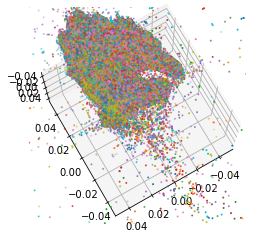

In [12]:
with open('X_C_I_Dino_500.pkl', 'rb') as handle:
       X_C_I_list = pkl.load(handle)

plot_all_triangulated(X_C_I_list[0], C_list = None, I_list = None, scale = 0.05, angle_list = [285, 300])

The above plot shows the triangulated points in the 3D space. As seen above, the outline of the object is well-defined. However, due to some reprojection errors, many outliers are seen floating around the object. In order to remove such detrimental points, outlier detection must be used to remove those points.

### Outlier Detection

Although the matching image points were projected onto the 3D world coordinate system, there are always reprojection errors to consider. Those outliers will be detrimental in the step where the silhouette is created. Thus, there needed to be a method of removing these outliers. Here are some approaches we considered:

- Distance cutoff on the distance between points and mean/median
- K-means on the distance between points and mean/median
- Multivariate Gaussian Distribution
- Gaussian Mixture Models
- One nearest neighbor
- IQR test


From here on out $X$ is a point in the 3d world coordinate system unless stated otherwise.

#### Distance Metrics

Generally, when projecting a large number of points, it can be assumed that the majority of the 3D points will be in the shape of the object. Thus, outliers will be substantially further from the majority of the points. One approach was a simple threshold cutoff. Taking either the mean or median $\bar{X}$ and given a threshold $T_{dist}$, only points satisfying the condition below were taken:

$$dist(X, \bar{X}) < T_{dist}$$

Though this is a naive approach, it works well in practice. Another way of implementing the threshold was applying the K-means algorithm. Taking either the mean or median $\bar{X}$, the distance between each $X$ and $\bar{X}$ was calculated. Then, the K-means algorithm was applied with a large number of clusters $k$. The idea here is outliers will be in clusters that are very small. Thus, points $X$ in cluster $C_i$ were taken if the size of $C_i$ is greater than a threshold $T_{kmeans}$. In other words:

$$|C_i| > T_{kmeans}$$

Another possible distance metric used was the one-nearest neighbor algorithm. For every point, the distance between itself and the nearest point was calculated. Given a threshold $T_{nn}$, if the distance is short enough, the points were kept. In other words:

$$dist(X, X_{closest}) < T_{nn}$$


#### Gaussian Metrics

If a multivariate gaussian was fit on the data points, points further away from the mean would imply that it is unlikely for the outliers to come from the fitted distribution. Thus, a multivariate Gaussian model was fit with CDF $F$ and a threshold of probability $p_g$ such that points were taken if:

$$p_g<F(X)<1-p_g$$

However, using a single Gaussian model may not be the best approach as the points on the object may not follow a single gaussian distribution. Thus, a gaussian mixture model was used in order to improve the accuracy of detecting the outliers. We fit $k$ components onto the data and computed the log-likelihood $l(X)$. Then a threshold of probability $p_{gmm}$ such that point were taken if:

$$l(X) < p_{gmm}$$

#### Other Metrics

Taking inspiration from statistics, the inter-quartile range was used to eliminate preliminary outliers. In other words, given the first and third quantiles $Q1$ and $Q3$ respectively, we can calculate the $IQR = Q3-Q1$. We only keep points if:

$$Q1 - 1.5 IQR < X < Q3 + 1.5 IQR$$


In [13]:
with open('X_C_I_Dino_500.pkl', 'rb') as handle:
       X_C_I_list = pkl.load(handle)
        
X_list = X_C_I_list[0]
X = np.vstack(X_list).squeeze(axis = 2).T
X = X.T

# Distance Metrics:

X_kmeans = kmeans(X, k = 200, threshold = 10, ismean = False)
X_spatial = spatial_cutoff(X, threshold = 0.1, ifmean = False)

# Gaussian Metrics:
X_gaussian = gaussian(X, ismean=False, alpha = 0.05)
X_gmm = gmm_cutoff(X, k = 4, threshold = 8)

# Other Metrics:
X_nn = nearestn(X, n_neighbor = 1, n_int = 1, threshold = 0.001)
X_IQR = IQR_test(X)

Starting K-MEANS
Points lost:  247
Points remaining: 80134
Points lost: 27270
Points remaining: 53111
Starting NN
0
Points lost: 6491
Points remaining: 73890
Points lost: 1189
Points remaining: 79192


In [14]:
# Order of which was used
X_clean = spatial_cutoff(X, 0.1)
X_clean = gmm_cutoff(X_clean, 4, 6)

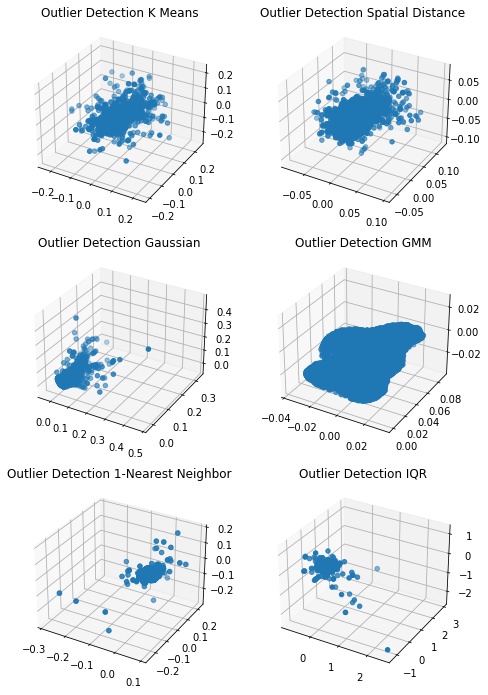

In [15]:
fig = plt.figure(4,figsize = (8, 12))

plot_3d(X_kmeans,'Outlier Detection K Means', fig.add_subplot(321,projection='3d'))
plot_3d(X_spatial,'Outlier Detection Spatial Distance', fig.add_subplot(322,projection='3d'))
plot_3d(X_gaussian,'Outlier Detection Gaussian', fig.add_subplot(323,projection='3d'))
plot_3d(X_gmm,'Outlier Detection GMM', fig.add_subplot(324,projection='3d'))
plot_3d(X_nn,'Outlier Detection 1-Nearest Neighbor', fig.add_subplot(325,projection='3d'))
plot_3d(X_IQR,'Outlier Detection IQR', fig.add_subplot(326,projection='3d'))

plt.show()

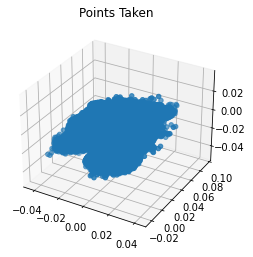

In [16]:
fig = plt.figure()
plot_3d(X_clean, 'Points Taken', fig.add_subplot(111,projection='3d'))
plt.show()

### Optimization

#### Convex Optimization

We used the ConvexHull function in the ”Scipy” package for computing the 3D convex hull. This function selects the convex points on the point clusters, computes triangulation, and applies triangulation to the convex points. The result from 3D point convex reconstruction looks distinctively different from the original image for a few reasons:
1. The original object may not be convex
2. Outliers exist in the object that hides the details of the object

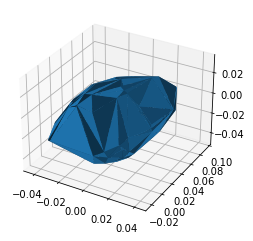

In [17]:
tri = convex_mesh(X_clean.T)

#### Concave Hull

We also adopted the alpha space method [Edelsbrunner]. According to the original paper, this is done by creating a $\alpha$ controlled subgraphs from the closest point triangulation. These subgraphs are called $\alpha$-hulls.

Let $\alpha \in \mathbf{R}$:

* $\alpha > 0$ and sufficiently small $\implies$ $\alpha$-hull is the intersection of all closed disk of radius $\frac{1}{\alpha}$ containing all the points
* $\alpha < 0$  $\implies$ $\alpha$-hull is the intersection of all the compliment of the closed disk of radius $-\frac{1}{\alpha}$ containing all the points
* $\alpha = 0 \implies$ a simple closed convex hull

Some examples illustrated in the paper are as follows:

<div>
<img src="imgs/alphahull.png" width="300"/>
</div>

In this problem, the object of interest is the dinosaur. Thus, we will work with $\alpha > 0$ since the ground truth reconstruction should not contain holes.

We fine-tuned the alpha value for each image to acquire a decent-looking object reconstruction.

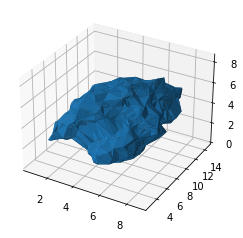

In [18]:
# %matplotlib notebook
%matplotlib inline
X_clean_concave = X_clean - np.min(X_clean)
X_clean_concave = X_clean_concave * 100
vertices, faces = concave_mesh(X_clean_concave, alpha = 1.3)

### Discussion


#### Background Removal

#### Epipolar Line Accuracy

The Dino Images come with projection matrices. Thus, calculating the fundamental matrix and projecting a point from one image plane to another was accurate. Discrepancies arose when the points on the epipolar line had to be estimated to find the matching pair. As the camera translation was quite parallel (as it goes around a ring most of the time), the epipolar lines were generally parallel. Thus sampling the same number of points for each epipolar line produced approximately the same number of matches, but in the extreme cases of parallel or vertical lines, many of the points overlapped when rounding.

Overall, finding matching pairs was as accurate as it could be while making use of the penalties from photoconsistency, amount of shift of the epipolar line, and the amount of distance of the matched point to its projection on the between the start and end of the region being matched. The weights on these penalties needed to be tuned to make them compatible with each other. Different powers of penalizing the distance from the matched point to its projection could also be used in order to keep more points and only remove grossly mismatched points. 

#### Triangulation

The triangulation method used in the assignments seemed to work well here. It helped that in our data set, the changes in the camera angle and position between different images were not too significant to make it difficult to find matches.  

#### Outlier Removal Analysis

As more points are sampled, the number of outliers becomes heavily present in the data. Thus, metrics such as the mean may be influenced too much by these points. Thus, the methods such as K-means (which is sensitive to outliers) failed to provide sufficient results. The one nearest neighbor algorithm did not provide sufficient results because of the sheer number of outliers. For this to work more efficiently, it must be iterated multiple times. However, doing so affects the original object's inliers as well. Thus, this method is not robust to outliers. The IQR test seems to remove most of the outliers, but a few far ones (near the edges of the IQR) are still present. A single Gaussian model was not enough to fit the entire data points since there are parts of the dinosaur which does not follow a proper Gaussian distribution (the tail compared to the body). Overall, the best option is a mix between the spatial cutoff and the GMM. Since a large number of data points are sampled, it is expected that GMM would perform very well. The shape of the object is well-preserved. Thus, we chose to mix the two outlier detection models to remove any outliers.

#### 3D Reconstruction

Our result from points triangulated is clustering around the actual object. We chose to use the alpha space reconstruction over the convex hull recreation. The result from 3D point convex reconstruction looks distinctively different from the original image for a few reasons:
* The original object may not be convex
* Outliers exist in the object that hides the details of the object 

However, there is still a gap between our alpha space reconstruction and the actual object. This is primarily due to the following reasons:

* Reconstruction error on the surface of the point clusters results in the rough surfacing of the reconstructed object. 
* The alpha concave hull algorithm creates disks around each point and takes the intersection of all of the disks. This results in hard edges on the surface rather than the smooth surface, as shown in the original object image (when alpha is large). However, having a smaller alpha goes back to the convex hull case, which is too smooth. 
* The distribution of points is inconsistent throughout the cluster. It is clear that most of the triangulated points come from the edge line of the image. This is not ideal for alpha space reconstruction because alpha controls the radius between all points. By having not uniformly distributed points, it is very hard to fine-tune the alpha value.

<div>
<img src="imgs/reconstructed.png" width="300"/>
</div>

### Conclusion

We were successful in creating an efficient modular workflow. By finding sequential pairs of images and projecting the match points onto the world coordinate center, we identified and minimized any potential issues with the current algorithms chosen and the general case. Thus in the future, the focus would be to find algorithms that will improve the accuracy rather than the workflow. Although the reconstructed 3D surface is not as refined, there is room for advancement. Future plans include:

- volumetric graph cuts and photoconsistency to smooth the 3D reconstruction
- interactive graph-cuts for background/object detection
- better depth-based background removal
- more robust penalty metrics for match-pairs
- gaussian penalty kernel on robust match-pairs rather than the linear penalty

### References

- Ghosh, Sourish. “Calculating the Fundamental Matrix from Camera Matrices.” Sourish Ghosh, https://sourishghosh.com/2016/fundamental-matrix-from-camera-matrices/. 
- Wu, Kai. Triangulation, https://imkaywu.github.io/blog/2017/07/triangulation/. 
- Xu, Ning, et al. "Deep image matting." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.
- “Object Detection.” OpenCV, https://docs.opencv.org/4.x/df/dfb/group__imgproc__object.html#gga3a7850640f1fe1f58fe91a2d7583695daf9c3ab9296f597ea71f056399a5831da. 
- Edelsbrunner, Herbert, David Kirkpatrick, and Raimund Seidel. "On the shape of a set of points in the plane." IEEE Transactions on information theory 29.4 (1983): 551-559.
- O. Enqvist, F. Kahl and C. Olsson, "Non-sequential structure from motion," 2011 IEEE International Conference on Computer Vision Workshops (ICCV Workshops), 2011, pp. 264-271, doi: 10.1109/ICCVW.2011.6130252.
- Olsson, Carl & Enqvist, Olof. (2011). Stable Structure from Motion for Unordered Image Collections. 524-535. 10.1007/978-3-642-21227-7_49. 